In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt         

In [2]:

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost
        
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))
        
        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance
        
    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}
    
    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]    
        amount = int(self.initial_balance * action[1] / current_price)
    
        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)
        
        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value 
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio
         
        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()
        
        self.current_step += 1
        
        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False
        
        self.done = done

        info = {}  
        return obs, reward, done, False,info
    
    
    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])
    
    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]
        
        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)
    
    def render_all(self):
        df = self.render_df.set_index('Date')       
        fig, ax = plt.subplots(figsize=(18, 6)) 
        df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey') 
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')
         
        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')

In [3]:
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')
from stable_baselines3 import PPO

In [4]:
yfinance = YFinance()
dftrain = yfinance.query(['AAPL'], start_date='1/1/2011', end_date='1/1/2024')
dftrain['date'] = pd.to_datetime(dftrain['date']).dt.date

Loading bar data...


[*********************100%***********************]  1 of 1 completed

Loaded bar data: 0:00:01 



In [5]:
dftrain

,date,symbol,open,high,low,close,volume,adj_close
0,2011-01-03,AAPL,11.630000,11.795000,11.601429,11.770357,445138400,9.928850
1,2011-01-04,AAPL,11.872857,11.875000,11.719643,11.831786,309080800,9.980671
2,2011-01-05,AAPL,11.769643,11.940714,11.767857,11.928571,255519600,10.062310
3,2011-01-06,AAPL,11.954286,11.973214,11.889286,11.918929,300428800,10.054178
4,2011-01-07,AAPL,11.928214,12.012500,11.853571,12.004286,311931200,10.126184
...,...,...,...,...,...,...,...,...
3265,2023-12-22,AAPL,195.179993,195.410004,192.970001,193.600006,37122800,192.656189
3266,2023-12-26,AAPL,193.610001,193.889999,192.830002,193.050003,28919300,192.108841
3267,2023-12-27,AAPL,192.490005,193.500000,191.089996,193.149994,48087700,192.208359
3268,2023-12-28,AAPL,194.139999,194.660004,193.169998,193.580002,34049900,192.636261


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_1740\3704117180.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


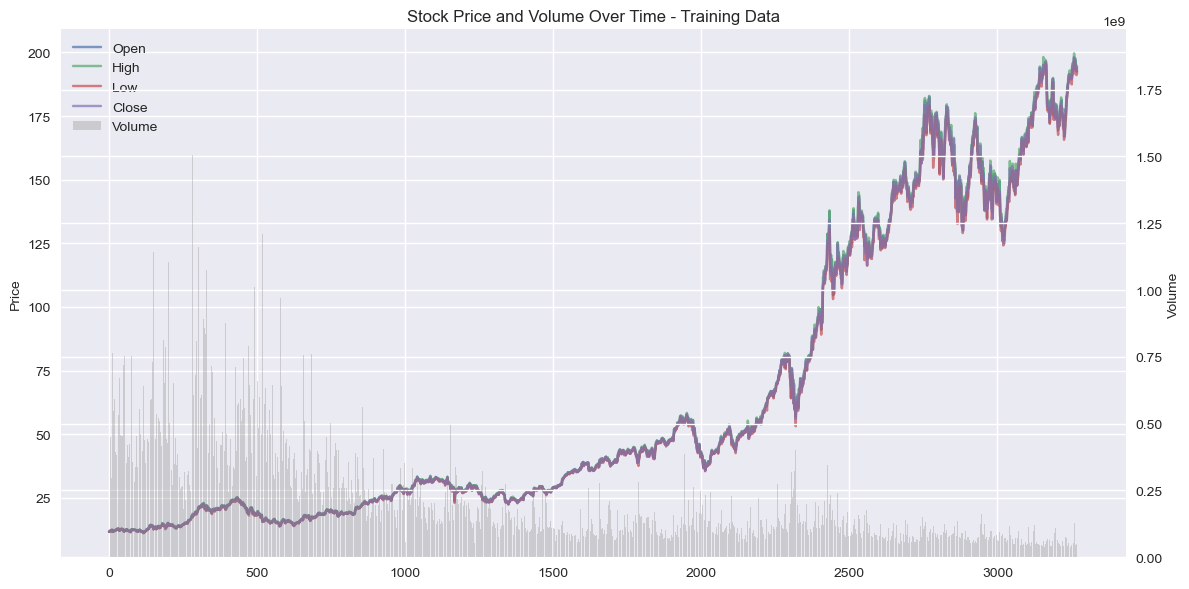

In [6]:
import seaborn as sns

# Set style
plt.style.use('seaborn')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot OHLC on primary axis
ax1.plot(dftrain.index, dftrain['open'], label='Open', alpha=0.7)
ax1.plot(dftrain.index, dftrain['high'], label='High', alpha=0.7)
ax1.plot(dftrain.index, dftrain['low'], label='Low', alpha=0.7)
ax1.plot(dftrain.index, dftrain['close'], label='Close', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(dftrain.index, dftrain['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume')

# Format
plt.title('Stock Price and Volume Over Time - Training Data')
plt.xticks(rotation=45)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [7]:
env = StockTradingEnv(dftrain, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100_000, progress_bar=True)
model.save("ppo_aapl")

Output()

In [8]:
yfinance = YFinance()
dftest = yfinance.query(['AAPL'], start_date='1/1/2024', end_date='11/15/2024')
dftest['date'] = pd.to_datetime(dftest['date']).dt.date
dftest


Loading bar data...


[*********************100%***********************]  1 of 1 completed

Loaded bar data: 0:00:00 



,date,symbol,open,high,low,close,volume,adj_close
0,2024-01-02,AAPL,187.149994,188.440002,183.889999,185.639999,82488700,184.734985
1,2024-01-03,AAPL,184.220001,185.880005,183.429993,184.250000,58414500,183.351761
2,2024-01-04,AAPL,182.149994,183.089996,180.880005,181.910004,71983600,181.023163
3,2024-01-05,AAPL,181.990005,182.759995,180.169998,181.179993,62303300,180.296722
4,2024-01-08,AAPL,182.089996,185.600006,181.500000,185.559998,59144500,184.655365
...,...,...,...,...,...,...,...,...
216,2024-11-08,AAPL,227.169998,228.660004,226.410004,226.960007,38328800,226.960007
217,2024-11-11,AAPL,225.000000,225.699997,221.500000,224.229996,42005600,224.229996
218,2024-11-12,AAPL,224.550003,225.589996,223.360001,224.229996,40398300,224.229996
219,2024-11-13,AAPL,224.009995,226.649994,222.759995,225.119995,48566200,225.119995


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_1740\3280022576.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


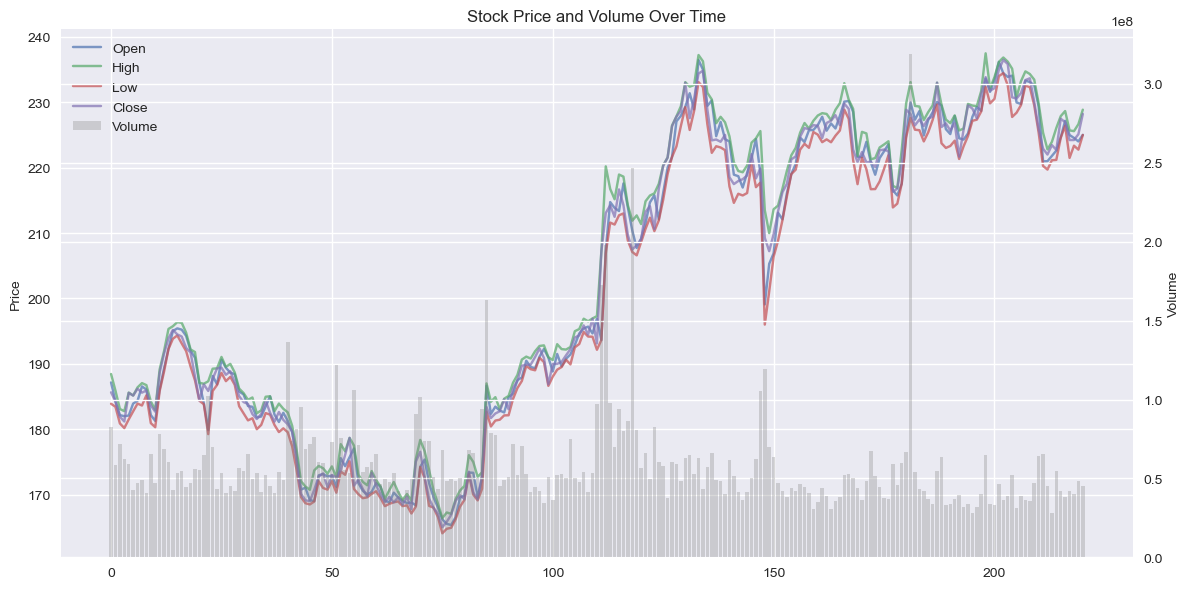

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot OHLC on primary axis
ax1.plot(dftest.index, dftest['open'], label='Open', alpha=0.7)
ax1.plot(dftest.index, dftest['high'], label='High', alpha=0.7)
ax1.plot(dftest.index, dftest['low'], label='Low', alpha=0.7)
ax1.plot(dftest.index, dftest['close'], label='Close', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(dftest.index, dftest['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume')

# Format
plt.title('Stock Price and Volume Over Time')
plt.xticks(rotation=45)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

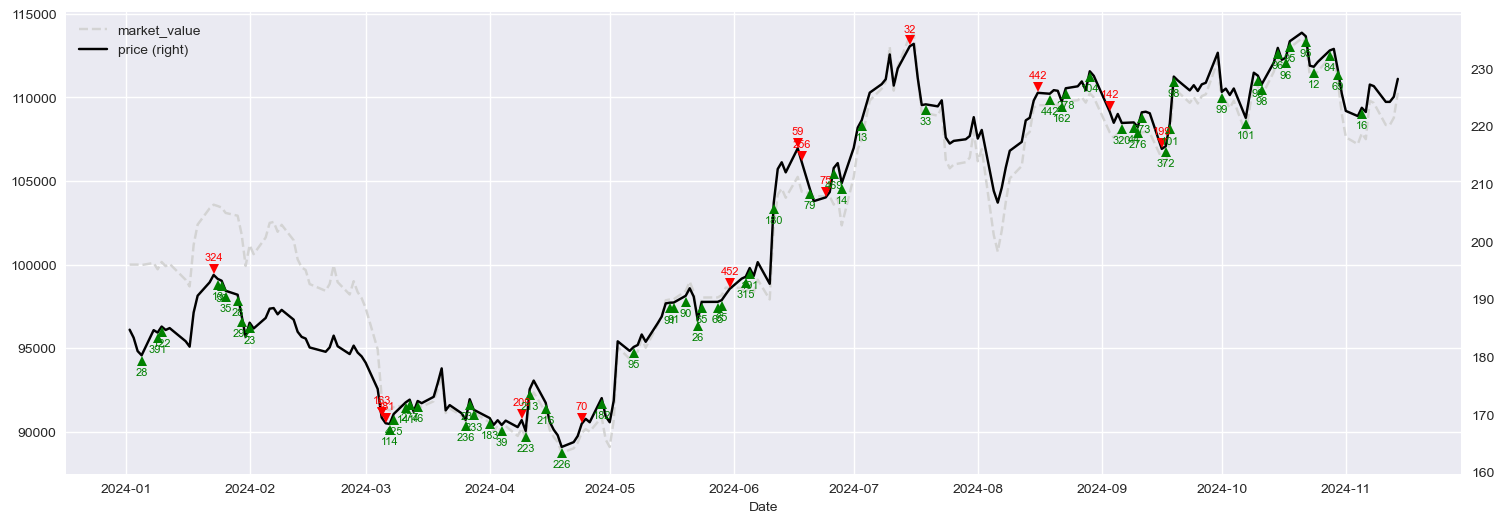

In [10]:
env = StockTradingEnv(dftest, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

model = PPO.load("ppo_aapl", env=env)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(len(dftest['adj_close'])):
    action, _state = model.predict(obs)
    obs, reward, done, info = vec_env.step(action)

env.render_all()

In [11]:
def calculate_accuracy(env):
    profitable_trades = 0
    total_trades = 0
    render_df = env.render_df.reset_index()  # Reset the index for safe access
    for idx in range(len(render_df) - 1):  # Stop at the second-to-last index
        action = render_df.loc[idx]['action']
        if action in ['buy', 'sell']:
            total_trades += 1
            if (action == 'buy' and render_df.loc[idx]['price'] < render_df.loc[idx + 1]['price']) or \
               (action == 'sell' and render_df.loc[idx]['price'] > render_df.loc[idx + 1]['price']):
                profitable_trades += 1
    return profitable_trades / total_trades if total_trades > 0 else 0

In [12]:
def calculate_roi(env):
    final_portfolio_value = env.render_df['market_value'].iloc[-1]
    initial_balance = env.initial_balance
    return ((final_portfolio_value - initial_balance) / initial_balance) * 100


In [13]:
accuracy = calculate_accuracy(env)
print(f"Accuracy: {accuracy:.2%}")

roi = calculate_roi(env)
print(f"ROI: {roi:.2f}%")


Accuracy: 53.18%
ROI: 10.28%
